# Imports and data loading

**Experiment**: <br>
1. Inputs : Modal_price from time t-0 to t-5
2. Output : Modal_price from time t+1 to t+5
3. Models : 
  1. Encoder-Decoder LSTM.
  2. Encoder-Decoder Bi-Dir LSTM.

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Dropout
#from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [2]:
from keras.losses import mean_absolute_percentage_error 

In [88]:
from keras.optimizers import Adam, SGD, RMSprop

In [3]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
from keras.layers import RepeatVector

In [5]:
from sklearn.model_selection import GridSearchCV

In [6]:
pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from scikeras.wrappers import KerasRegressor

In [8]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [9]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [10]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [11]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [12]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [13]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [14]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [15]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

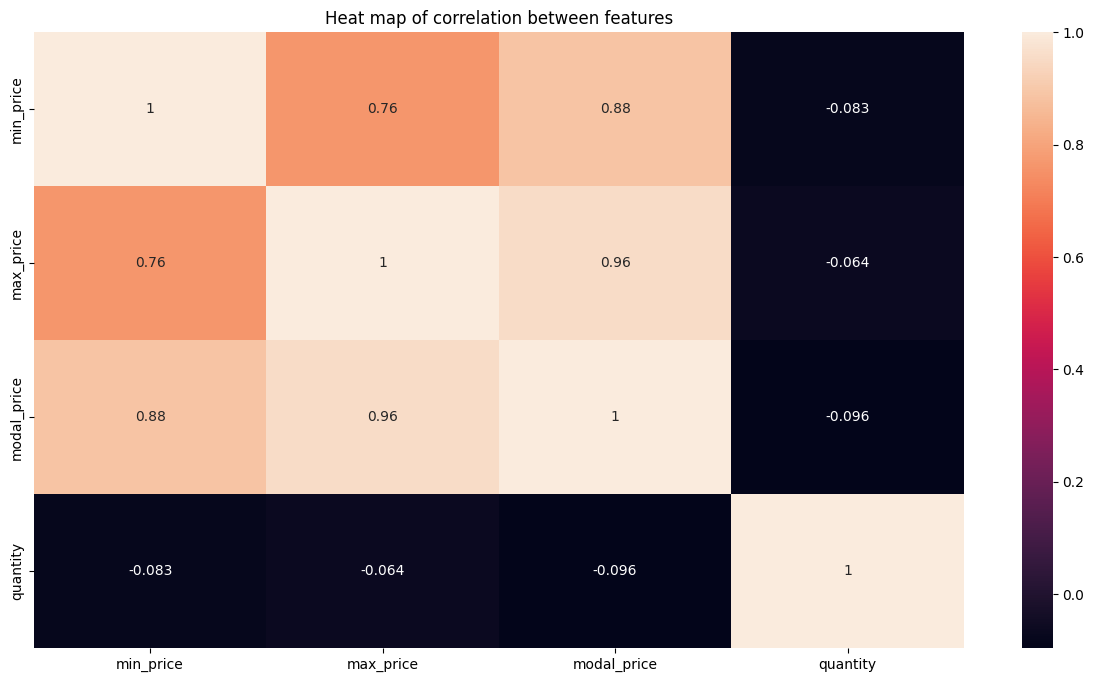

In [16]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [17]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [18]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [19]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,modal_price
arrival_date,
2020-01-01,733
2020-01-02,986
2020-01-03,1047
2020-01-04,1033
2020-01-05,1033


# Preparing the dataset for training

### Creating Feature variable

In [20]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(0,winSize):
    df_temp["modal_price_t"+str(i+1)] = df_tomato_3['modal_price'].shift(i)
  return df_temp

In [21]:
# Generating new features
df_newFeatures = createWindow(5)
df_newFeatures.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,NaN,NaN,NaN,NaN
2020-01-02,986,733.0,NaN,NaN,NaN
2020-01-03,1047,986.0,733.0,NaN,NaN
2020-01-04,1033,1047.0,986.0,733.0,NaN
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [22]:
# joining with base dataframe
df_tomato_4 = df_newFeatures.copy()
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,NaN,NaN,NaN,NaN
2020-01-02,986,733.0,NaN,NaN,NaN
2020-01-03,1047,986.0,733.0,NaN,NaN
2020-01-04,1033,1047.0,986.0,733.0,NaN
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [23]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5
arrival_date,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0
2020-01-02,986,733.0,0.0,0.0,0.0
2020-01-03,1047,986.0,733.0,0.0,0.0
2020-01-04,1033,1047.0,986.0,733.0,0.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0


In [24]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [25]:
# Function to create as many as features to represent the window size
def createTargetWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_modal_price_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [26]:
# Generating target columns
df_newTargetCols = createTargetWindow(5)
df_newTargetCols.head()

,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [27]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,1046.0,1153.0,933.0,1133.0,933.0


In [28]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,733,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,986,733.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1047,986.0,733.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033,1047.0,986.0,733.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1033,1033.0,1047.0,986.0,733.0,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1000,1200.0,1130.0,1000.0,1000.0,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,1270,1000.0,1200.0,1130.0,1000.0,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,1200,1270.0,1000.0,1200.0,1130.0,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [29]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2020-01-01,0.091897,0.000000,0.000000,0.000000,0.000000,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.135517,0.122167,0.000000,0.000000,0.000000,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.146034,0.164333,0.122167,0.000000,0.000000,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.143621,0.174500,0.164333,0.122167,0.000000,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.143621,0.172167,0.174500,0.164333,0.122167,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [30]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [31]:
# Creating Training dataset
train_X = pd.DataFrame(index=train_data.index)
train_y = pd.DataFrame(index=train_data.index)
for i in train_data.columns:
  if i.startswith('target'):
    train_y[i] = train_data[i]
  else:
    train_X[i] = train_data[i]

In [32]:
# Creating Testing dataset
test_X = pd.DataFrame(index=test_data.index)
test_y = pd.DataFrame(index=test_data.index)
for i in test_data.columns:
  if i.startswith('target'):
    test_y[i] = test_data[i]
  else:
    test_X[i] = test_data[i]

In [33]:
# Splitting target and feature variables
#train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

#test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [34]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [71]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((train_X.shape[0], 5, 1))
vec_train_y = vec_train_y.reshape((train_y.shape[0], 5, 1))

vec_test_X = vec_test_X.reshape((test_X.shape[0], 5, 1))
vec_test_y  = vec_test_y.reshape((test_y.shape[0], 5, 1))

In [72]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 5) (926, 5) (232, 5) (232, 5)


In [74]:
vec_train_X[10,:]

array([0.16431034, 0.1555    , 0.18883333, 0.1555    , 0.19216667])

# Model - Encoder - Decoder model using LSTM

## Model building

In [82]:
# Build the Encoder - Decoder using LSTM model
# define model
def create_model():
  model_encDec_1 = Sequential()
  model_encDec_1.add(LSTM(128, activation='relu', 
                          input_shape=(vec_train_X.shape[1]), 
                          return_sequences=True))
  model_encDec_1.add(Dropout(0.2))
  model_encDec_1.add(LSTM(64, activation='relu', return_sequences=False))
  model_encDec_1.add(Dropout(0.2))
  model_encDec_1.add(RepeatVector(vec_train_y.shape[1]))
  model_encDec_1.add(Dropout(0.2))
  model_encDec_1.add(LSTM(64, activation='relu', return_sequences=True))
  model_encDec_1.add(Dropout(0.2))
  model_encDec_1.add(LSTM(128, activation='relu', return_sequences=True))
  model_encDec_1.add(Dropout(0.2))
  model_encDec_1.add(TimeDistributed(Dense(vec_train_y.shape[1])))
  model_encDec_1.compile(optimizer='adam', loss='mae', metrics=['mean_absolute_error'])
  #model_encDec_1.summary()
  return model_encDec_1

In [83]:
# Define the callback function
calls=[
    EarlyStopping(monitor='mae', patience=10), 
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks', monitor='mae', save_best_only=True, mode='auto', save_freq=1)
    ]

In [84]:
# create model
lstm_regressor = KerasRegressor(build_fn=create_model, callbacks=calls)

## Hyperparameter Tuning

In [85]:
# define the grid search parameters
optimizers = ['adam'] #['rmsprop', 'adam', 'SGD']
batches = [50, 100, 250, 500, 1000]
epoch_values = [100] #[100, 250, 500]
lr_values = [0.01] #[0.001, 0.01, 0.1, 0.2, 0.3]
momentum_values = [0.2] #[0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(optimizer = optimizers, 
                  epochs = epoch_values, 
                  batch_size = batches,
                  optimizer__learning_rate = lr_values,
                  optimizer__momentum = momentum_values
                  )

In [86]:
# Initialising the GridSearchCV
grid = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, n_jobs=-1, cv=3)

In [87]:
# Fitting the model
grid_result = grid.fit(vec_train_X, vec_train_y, validation_data = (vec_test_X, vec_test_y), callbacks=calls)

ValueError: ignored

## Finding Best Parameter

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

## Training with best parameters

In [44]:
# Build the model
model_encDec_tune = Sequential()
model_encDec_tune.add(LSTM(128, activation='relu', 
                        input_shape=(vec_train_X.shape[1], vec_train_X.shape[2]), 
                        return_sequences=True))
model_encDec_tune.add(Dropout(0.2))
model_encDec_tune.add(LSTM(64, activation='relu', return_sequences=False))
model_encDec_tune.add(Dropout(0.2))
model_encDec_tune.add(RepeatVector(vec_train_y.shape[1]))
model_encDec_tune.add(Dropout(0.2))
model_encDec_tune.add(LSTM(64, activation='relu', return_sequences=True))
model_encDec_tune.add(Dropout(0.2))
model_encDec_tune.add(LSTM(128, activation='relu', return_sequences=True))
model_encDec_tune.add(Dropout(0.2))
model_encDec_tune.add(TimeDistributed(Dense(vec_train_X.shape[2])))
# Compile model
model_encDec_tune.compile(optimizer='adam', loss='mae', metrics=['mean_absolute_error'])

In [ ]:
model_encDec_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 5, 64)            0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                        

In [46]:
# fit network
history = model_encDec_tune.fit(vec_train_X, vec_train_y, epochs=50, batch_size=100, 
                             validation_data=(vec_test_X, vec_test_y), verbose=1,callbacks=calls,
                             shuffle=False)

Epoch 1/50


 1/10 [==>...........................] - ETA: 45s - loss: 0.0762 - mean_absolute_error: 0.0762

 3/10 [========>.....................] - ETA: 0s - loss: 0.1525 - mean_absolute_error: 0.1525 

 5/10 [==============>...............] - ETA: 0s - loss: 0.1301 - mean_absolute_error: 0.1301

 7/10 [====================>.........] - ETA: 0s - loss: 0.1287 - mean_absolute_error: 0.1287

 9/10 [==========================>...] - ETA: 0s - loss: 0.1487 - mean_absolute_error: 0.1487

10/10 [==============================] - 6s 91ms/step - loss: 0.1460 - mean_absolute_error: 0.1460 - val_loss: 0.0787 - val_mean_absolute_error: 0.0787
Epoch 2/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.0401

 3/10 [========>.....................] - ETA: 0s - loss: 0.1003 - mean_absolute_error: 0.1003

 5/10 [==============>...............] - ETA: 0s - loss: 0.0887 - mean_absolute_error: 0.0887

 7/10 [====================>.........] - ETA: 0s - loss: 0.0960 - mean_absolute_error: 0.0960

 9/10 [==========================>...] - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.1161

10/10 [==============================] - 0s 39ms/step - loss: 0.1145 - mean_absolute_error: 0.1145 - val_loss: 0.0687 - val_mean_absolute_error: 0.0687
Epoch 3/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0715 - mean_absolute_error: 0.0715

 3/10 [========>.....................] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.1001

 5/10 [==============>...............] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.0891

 7/10 [====================>.........] - ETA: 0s - loss: 0.0961 - mean_absolute_error: 0.0961

 9/10 [==========================>...] - ETA: 0s - loss: 0.1159 - mean_absolute_error: 0.1159

10/10 [==============================] - 0s 38ms/step - loss: 0.1140 - mean_absolute_error: 0.1140 - val_loss: 0.0641 - val_mean_absolute_error: 0.0641
Epoch 4/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0573 - mean_absolute_error: 0.0573

 3/10 [========>.....................] - ETA: 0s - loss: 0.0981 - mean_absolute_error: 0.0981

 5/10 [==============>...............] - ETA: 0s - loss: 0.0844 - mean_absolute_error: 0.0844

 7/10 [====================>.........] - ETA: 0s - loss: 0.0905 - mean_absolute_error: 0.0905

 9/10 [==========================>...] - ETA: 0s - loss: 0.1109 - mean_absolute_error: 0.1109

10/10 [==============================] - 0s 38ms/step - loss: 0.1090 - mean_absolute_error: 0.1090 - val_loss: 0.0621 - val_mean_absolute_error: 0.0621
Epoch 5/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.0471

 3/10 [========>.....................] - ETA: 0s - loss: 0.0925 - mean_absolute_error: 0.0925

 5/10 [==============>...............] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.0795

 7/10 [====================>.........] - ETA: 0s - loss: 0.0845 - mean_absolute_error: 0.0845

 9/10 [==========================>...] - ETA: 0s - loss: 0.1007 - mean_absolute_error: 0.1007

10/10 [==============================] - 0s 42ms/step - loss: 0.0992 - mean_absolute_error: 0.0992 - val_loss: 0.0570 - val_mean_absolute_error: 0.0570
Epoch 6/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0506 - mean_absolute_error: 0.0506

 3/10 [========>.....................] - ETA: 0s - loss: 0.0781 - mean_absolute_error: 0.0781

 5/10 [==============>...............] - ETA: 0s - loss: 0.0686 - mean_absolute_error: 0.0686

 7/10 [====================>.........] - ETA: 0s - loss: 0.0716 - mean_absolute_error: 0.0716

 9/10 [==========================>...] - ETA: 0s - loss: 0.0843 - mean_absolute_error: 0.0843

10/10 [==============================] - 0s 41ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0534 - val_mean_absolute_error: 0.0534
Epoch 7/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

 3/10 [========>.....................] - ETA: 0s - loss: 0.0698 - mean_absolute_error: 0.0698

 5/10 [==============>...............] - ETA: 0s - loss: 0.0600 - mean_absolute_error: 0.0600

 7/10 [====================>.........] - ETA: 0s - loss: 0.0609 - mean_absolute_error: 0.0609

 9/10 [==========================>...] - ETA: 0s - loss: 0.0760 - mean_absolute_error: 0.0760

10/10 [==============================] - 0s 38ms/step - loss: 0.0750 - mean_absolute_error: 0.0750 - val_loss: 0.0526 - val_mean_absolute_error: 0.0526
Epoch 8/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276

 3/10 [========>.....................] - ETA: 0s - loss: 0.0671 - mean_absolute_error: 0.0671

 5/10 [==============>...............] - ETA: 0s - loss: 0.0577 - mean_absolute_error: 0.0577

 7/10 [====================>.........] - ETA: 0s - loss: 0.0585 - mean_absolute_error: 0.0585

 9/10 [==========================>...] - ETA: 0s - loss: 0.0693 - mean_absolute_error: 0.0693

10/10 [==============================] - 0s 43ms/step - loss: 0.0689 - mean_absolute_error: 0.0689 - val_loss: 0.0487 - val_mean_absolute_error: 0.0487
Epoch 9/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

 3/10 [========>.....................] - ETA: 0s - loss: 0.0567 - mean_absolute_error: 0.0567

 5/10 [==============>...............] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

 7/10 [====================>.........] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511

 9/10 [==========================>...] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.0613

10/10 [==============================] - 0s 38ms/step - loss: 0.0608 - mean_absolute_error: 0.0608 - val_loss: 0.0440 - val_mean_absolute_error: 0.0440
Epoch 10/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0245 - mean_absolute_error: 0.0245

 3/10 [========>.....................] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.0487

 5/10 [==============>...............] - ETA: 0s - loss: 0.0428 - mean_absolute_error: 0.0428

 7/10 [====================>.........] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.0437

 9/10 [==========================>...] - ETA: 0s - loss: 0.0534 - mean_absolute_error: 0.0534

10/10 [==============================] - 0s 40ms/step - loss: 0.0532 - mean_absolute_error: 0.0532 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382
Epoch 11/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.0241

 3/10 [========>.....................] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.0471

 5/10 [==============>...............] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.0400

 7/10 [====================>.........] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

 9/10 [==========================>...] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.0509

10/10 [==============================] - 0s 38ms/step - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 12/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0243

 3/10 [========>.....................] - ETA: 0s - loss: 0.0399 - mean_absolute_error: 0.0399

 5/10 [==============>...............] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

 7/10 [====================>.........] - ETA: 0s - loss: 0.0388 - mean_absolute_error: 0.0388

 9/10 [==========================>...] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.0468

10/10 [==============================] - 0s 43ms/step - loss: 0.0470 - mean_absolute_error: 0.0470 - val_loss: 0.0371 - val_mean_absolute_error: 0.0371
Epoch 13/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.0256

 3/10 [========>.....................] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.0405

 5/10 [==============>...............] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

 7/10 [====================>.........] - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.0390

 9/10 [==========================>...] - ETA: 0s - loss: 0.0468 - mean_absolute_error: 0.0468

10/10 [==============================] - 0s 42ms/step - loss: 0.0467 - mean_absolute_error: 0.0467 - val_loss: 0.0334 - val_mean_absolute_error: 0.0334
Epoch 14/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0243 - mean_absolute_error: 0.0243

 3/10 [========>.....................] - ETA: 0s - loss: 0.0374 - mean_absolute_error: 0.0374

 5/10 [==============>...............] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334

 7/10 [====================>.........] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

 9/10 [==========================>...] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.0426

10/10 [==============================] - 0s 42ms/step - loss: 0.0425 - mean_absolute_error: 0.0425 - val_loss: 0.0336 - val_mean_absolute_error: 0.0336
Epoch 15/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.0225

 3/10 [========>.....................] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

 5/10 [==============>...............] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

 7/10 [====================>.........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

 9/10 [==========================>...] - ETA: 0s - loss: 0.0416 - mean_absolute_error: 0.0416

10/10 [==============================] - 0s 41ms/step - loss: 0.0416 - mean_absolute_error: 0.0416 - val_loss: 0.0315 - val_mean_absolute_error: 0.0315
Epoch 16/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.0225

 3/10 [========>.....................] - ETA: 0s - loss: 0.0355 - mean_absolute_error: 0.0355

 5/10 [==============>...............] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

 7/10 [====================>.........] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.0341

 9/10 [==========================>...] - ETA: 0s - loss: 0.0413 - mean_absolute_error: 0.0413

10/10 [==============================] - 0s 40ms/step - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.0309 - val_mean_absolute_error: 0.0309
Epoch 17/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.0232

 3/10 [========>.....................] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.0337

 5/10 [==============>...............] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299

 7/10 [====================>.........] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

 9/10 [==========================>...] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

10/10 [==============================] - 0s 40ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 18/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0227 - mean_absolute_error: 0.0227

 3/10 [========>.....................] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

 5/10 [==============>...............] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

 7/10 [====================>.........] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325

 9/10 [==========================>...] - ETA: 0s - loss: 0.0387 - mean_absolute_error: 0.0387

10/10 [==============================] - 0s 44ms/step - loss: 0.0388 - mean_absolute_error: 0.0388 - val_loss: 0.0299 - val_mean_absolute_error: 0.0299
Epoch 19/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0231 - mean_absolute_error: 0.0231

 3/10 [========>.....................] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

 5/10 [==============>...............] - ETA: 0s - loss: 0.0291 - mean_absolute_error: 0.0291

 7/10 [====================>.........] - ETA: 0s - loss: 0.0321 - mean_absolute_error: 0.0321

 9/10 [==========================>...] - ETA: 0s - loss: 0.0389 - mean_absolute_error: 0.0389

10/10 [==============================] - 0s 41ms/step - loss: 0.0389 - mean_absolute_error: 0.0389 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 20/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0227 - mean_absolute_error: 0.0227

 3/10 [========>.....................] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.0332

 5/10 [==============>...............] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.0297

 7/10 [====================>.........] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

 9/10 [==========================>...] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.0391

10/10 [==============================] - 0s 42ms/step - loss: 0.0391 - mean_absolute_error: 0.0391 - val_loss: 0.0299 - val_mean_absolute_error: 0.0299
Epoch 21/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0214

 3/10 [========>.....................] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336

 5/10 [==============>...............] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298

 7/10 [====================>.........] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

 8/10 [=======================>......] - ETA: 0s - loss: 0.0338 - mean_absolute_error: 0.0338

 9/10 [==========================>...] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

10/10 [==============================] - 1s 57ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 22/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0222

 2/10 [=====>........................] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266

 3/10 [========>.....................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

 4/10 [===========>..................] - ETA: 0s - loss: 0.0329 - mean_absolute_error: 0.0329

 5/10 [==============>...............] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294

 6/10 [=================>............] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266

 7/10 [====================>.........] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

 8/10 [=======================>......] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.0340

 9/10 [==========================>...] - ETA: 0s - loss: 0.0383 - mean_absolute_error: 0.0383

10/10 [==============================] - 1s 68ms/step - loss: 0.0386 - mean_absolute_error: 0.0386 - val_loss: 0.0299 - val_mean_absolute_error: 0.0299
Epoch 23/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.0226

 2/10 [=====>........................] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.0266

 3/10 [========>.....................] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

 4/10 [===========>..................] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

 5/10 [==============>...............] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.0282

 6/10 [=================>............] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.0256

 7/10 [====================>.........] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

 8/10 [=======================>......] - ETA: 0s - loss: 0.0328 - mean_absolute_error: 0.0328

 9/10 [==========================>...] - ETA: 0s - loss: 0.0377 - mean_absolute_error: 0.0377

10/10 [==============================] - 1s 67ms/step - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0300 - val_mean_absolute_error: 0.0300
Epoch 24/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0251 - mean_absolute_error: 0.0251

 2/10 [=====>........................] - ETA: 0s - loss: 0.0270 - mean_absolute_error: 0.0270

 3/10 [========>.....................] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

 4/10 [===========>..................] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.0322

 5/10 [==============>...............] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.0287

 6/10 [=================>............] - ETA: 0s - loss: 0.0259 - mean_absolute_error: 0.0259

 7/10 [====================>.........] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316

 8/10 [=======================>......] - ETA: 0s - loss: 0.0331 - mean_absolute_error: 0.0331

 9/10 [==========================>...] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385

10/10 [==============================] - 1s 66ms/step - loss: 0.0384 - mean_absolute_error: 0.0384 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295
Epoch 25/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0210 - mean_absolute_error: 0.0210

 2/10 [=====>........................] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264

 3/10 [========>.....................] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

 4/10 [===========>..................] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

 5/10 [==============>...............] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.0282

 6/10 [=================>............] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.0254

 7/10 [====================>.........] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301

 8/10 [=======================>......] - ETA: 0s - loss: 0.0324 - mean_absolute_error: 0.0324

 9/10 [==========================>...] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

10/10 [==============================] - 1s 64ms/step - loss: 0.0370 - mean_absolute_error: 0.0370 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 26/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.0222

 2/10 [=====>........................] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268

 3/10 [========>.....................] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

 4/10 [===========>..................] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

 5/10 [==============>...............] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.0282

 6/10 [=================>............] - ETA: 0s - loss: 0.0254 - mean_absolute_error: 0.0254

 7/10 [====================>.........] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0306

 8/10 [=======================>......] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.0326

 9/10 [==========================>...] - ETA: 0s - loss: 0.0375 - mean_absolute_error: 0.0375

10/10 [==============================] - 1s 68ms/step - loss: 0.0376 - mean_absolute_error: 0.0376 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 27/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212

 3/10 [========>.....................] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0305

 5/10 [==============>...............] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276

 6/10 [=================>............] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.0250

 8/10 [=======================>......] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.0323

10/10 [==============================] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

10/10 [==============================] - 0s 43ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 28/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0219

 3/10 [========>.....................] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304

 5/10 [==============>...............] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275

 7/10 [====================>.........] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.0308

 9/10 [==========================>...] - ETA: 0s - loss: 0.0371 - mean_absolute_error: 0.0371

10/10 [==============================] - 0s 47ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0294 - val_mean_absolute_error: 0.0294
Epoch 29/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0219 - mean_absolute_error: 0.0219

 3/10 [========>.....................] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301

 5/10 [==============>...............] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272

 7/10 [====================>.........] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

 9/10 [==========================>...] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

10/10 [==============================] - 0s 43ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 30/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0211

 3/10 [========>.....................] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309

 5/10 [==============>...............] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279

 7/10 [====================>.........] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303

 9/10 [==========================>...] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

10/10 [==============================] - 0s 43ms/step - loss: 0.0369 - mean_absolute_error: 0.0369 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 31/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212

 3/10 [========>.....................] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311

 5/10 [==============>...............] - ETA: 0s - loss: 0.0280 - mean_absolute_error: 0.0280

 7/10 [====================>.........] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298

 9/10 [==========================>...] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

10/10 [==============================] - 0s 42ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 32/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0209 - mean_absolute_error: 0.0209

 3/10 [========>.....................] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

 5/10 [==============>...............] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279

 7/10 [====================>.........] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304

 9/10 [==========================>...] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

10/10 [==============================] - 0s 43ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0289 - val_mean_absolute_error: 0.0289
Epoch 33/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0214

 3/10 [========>.....................] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0306

 5/10 [==============>...............] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273

 7/10 [====================>.........] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0305

 9/10 [==========================>...] - ETA: 0s - loss: 0.0369 - mean_absolute_error: 0.0369

10/10 [==============================] - 0s 42ms/step - loss: 0.0371 - mean_absolute_error: 0.0371 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 34/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0218 - mean_absolute_error: 0.0218

 3/10 [========>.....................] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.0305

 5/10 [==============>...............] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275

 7/10 [====================>.........] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

 9/10 [==========================>...] - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.0366

10/10 [==============================] - 0s 44ms/step - loss: 0.0368 - mean_absolute_error: 0.0368 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 35/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.0212

 3/10 [========>.....................] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312

 5/10 [==============>...............] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278

 7/10 [====================>.........] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301

 9/10 [==========================>...] - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.0365

10/10 [==============================] - 0s 44ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 36/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0217

 3/10 [========>.....................] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

 5/10 [==============>...............] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271

 7/10 [====================>.........] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

 9/10 [==========================>...] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

10/10 [==============================] - 0s 44ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 37/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.0207

 3/10 [========>.....................] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304

 5/10 [==============>...............] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.0272

 7/10 [====================>.........] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296

 9/10 [==========================>...] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

10/10 [==============================] - 0s 43ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0290 - val_mean_absolute_error: 0.0290
Epoch 38/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0209 - mean_absolute_error: 0.0209

 3/10 [========>.....................] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0306

 5/10 [==============>...............] - ETA: 0s - loss: 0.0277 - mean_absolute_error: 0.0277

 7/10 [====================>.........] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301

 9/10 [==========================>...] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.0362

10/10 [==============================] - 0s 43ms/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 39/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0214

 3/10 [========>.....................] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

 5/10 [==============>...............] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273

 7/10 [====================>.........] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301

 9/10 [==========================>...] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

10/10 [==============================] - 0s 43ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 40/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0217 - mean_absolute_error: 0.0217

 3/10 [========>.....................] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

 5/10 [==============>...............] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271

 7/10 [====================>.........] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294

 9/10 [==========================>...] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

10/10 [==============================] - 1s 50ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 41/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.0206

 3/10 [========>.....................] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311

 5/10 [==============>...............] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.0278

 7/10 [====================>.........] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296

 9/10 [==========================>...] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.0364

10/10 [==============================] - 0s 47ms/step - loss: 0.0366 - mean_absolute_error: 0.0366 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 42/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0214 - mean_absolute_error: 0.0214

 3/10 [========>.....................] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

 5/10 [==============>...............] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.0271

 7/10 [====================>.........] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299

 9/10 [==========================>...] - ETA: 0s - loss: 0.0363 - mean_absolute_error: 0.0363

10/10 [==============================] - 0s 45ms/step - loss: 0.0365 - mean_absolute_error: 0.0365 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288
Epoch 43/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0220 - mean_absolute_error: 0.0220

 3/10 [========>.....................] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313

 5/10 [==============>...............] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.0279

 7/10 [====================>.........] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0307

 9/10 [==========================>...] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.0370

10/10 [==============================] - 0s 46ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0286 - val_mean_absolute_error: 0.0286
Epoch 44/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.0205

 3/10 [========>.....................] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.0293

 5/10 [==============>...............] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.0264

 7/10 [====================>.........] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.0289

 9/10 [==========================>...] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.0353

10/10 [==============================] - 0s 44ms/step - loss: 0.0354 - mean_absolute_error: 0.0354 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 45/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0208 - mean_absolute_error: 0.0208

 3/10 [========>.....................] - ETA: 0s - loss: 0.0304 - mean_absolute_error: 0.0304

 5/10 [==============>...............] - ETA: 0s - loss: 0.0273 - mean_absolute_error: 0.0273

 7/10 [====================>.........] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296

 9/10 [==========================>...] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

10/10 [==============================] - 0s 46ms/step - loss: 0.0363 - mean_absolute_error: 0.0363 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 46/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.0211

 3/10 [========>.....................] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311

 5/10 [==============>...............] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.0276

 6/10 [=================>............] - ETA: 0s - loss: 0.0250 - mean_absolute_error: 0.0250

 8/10 [=======================>......] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

10/10 [==============================] - ETA: 0s - loss: 0.0360 - mean_absolute_error: 0.0360

10/10 [==============================] - 0s 45ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 47/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0215

 3/10 [========>.....................] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295

 4/10 [===========>..................] - ETA: 0s - loss: 0.0294 - mean_absolute_error: 0.0294

 6/10 [=================>............] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.0239

 8/10 [=======================>......] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314

10/10 [==============================] - ETA: 0s - loss: 0.0361 - mean_absolute_error: 0.0361

10/10 [==============================] - 0s 48ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 48/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.0203

 3/10 [========>.....................] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300

 5/10 [==============>...............] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.0268

 7/10 [====================>.........] - ETA: 0s - loss: 0.0293 - mean_absolute_error: 0.0293

 8/10 [=======================>......] - ETA: 0s - loss: 0.0315 - mean_absolute_error: 0.0315

10/10 [==============================] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

10/10 [==============================] - 1s 51ms/step - loss: 0.0358 - mean_absolute_error: 0.0358 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293
Epoch 49/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0205 - mean_absolute_error: 0.0205

 2/10 [=====>........................] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.0257

 3/10 [========>.....................] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309

 4/10 [===========>..................] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.0309

 5/10 [==============>...............] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275

 6/10 [=================>............] - ETA: 0s - loss: 0.0249 - mean_absolute_error: 0.0249

 7/10 [====================>.........] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.0295

 8/10 [=======================>......] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317

 9/10 [==========================>...] - ETA: 0s - loss: 0.0359 - mean_absolute_error: 0.0359

10/10 [==============================] - 1s 69ms/step - loss: 0.0361 - mean_absolute_error: 0.0361 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 50/50


 1/10 [==>...........................] - ETA: 0s - loss: 0.0215 - mean_absolute_error: 0.0215

 2/10 [=====>........................] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.0258

 3/10 [========>.....................] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.0302

 4/10 [===========>..................] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0307

 5/10 [==============>...............] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.0275

 6/10 [=================>............] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.0248

 7/10 [====================>.........] - ETA: 0s - loss: 0.0297 - mean_absolute_error: 0.0297

 8/10 [=======================>......] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.0319

 9/10 [==========================>...] - ETA: 0s - loss: 0.0358 - mean_absolute_error: 0.0358

10/10 [==============================] - 1s 63ms/step - loss: 0.0360 - mean_absolute_error: 0.0360 - val_loss: 0.0288 - val_mean_absolute_error: 0.0288


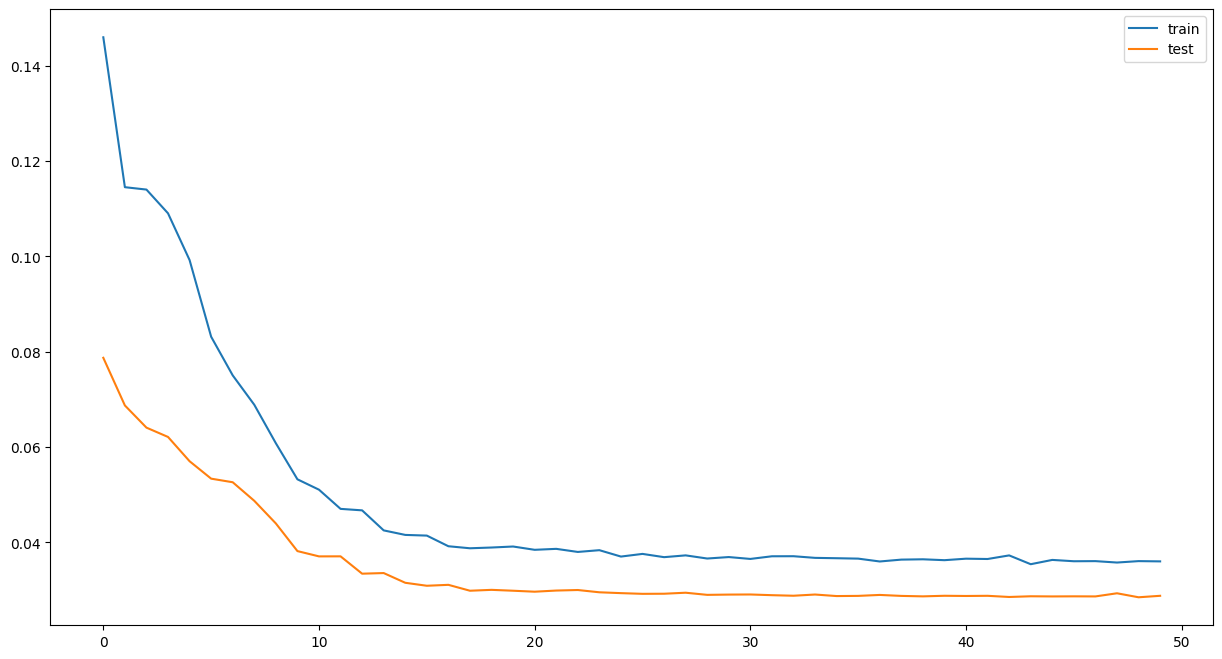

In [49]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [50]:
# make a prediction
pred_y = model_encDec_tune.predict(vec_test_X)

8/8 [==============================] - 1s 9ms/step


In [51]:
pred_y[:5]

array([[[0.08745793],
        [0.08842947],
        [0.08676947],
        [0.08530919],
        [0.08433215]],

       [[0.0893136 ],
        [0.09038456],
        [0.088673  ],
        [0.08714729],
        [0.08612546]],

       [[0.08646397],
        [0.08739221],
        [0.08576968],
        [0.08435164],
        [0.08341014]],

       [[0.08941388],
        [0.09049249],
        [0.08877921],
        [0.08725166],
        [0.08623017]],

       [[0.09141807],
        [0.09259762],
        [0.09082885],
        [0.0892182 ],
        [0.08813743]]], dtype=float32)

In [52]:
pred_y.shape

(232, 5, 1)

## Resacling Prediction

In [53]:
test_data

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,target_modal_price_t1,target_modal_price_t2,target_modal_price_t3,target_modal_price_t4,target_modal_price_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.091379,0.081034,0.091379,0.091379,0.046552
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.081034,0.091379,0.091379,0.046552,0.056897
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.091379,0.091379,0.046552,0.056897,0.068966
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.091379,0.046552,0.056897,0.068966,0.081034
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.046552,0.056897,0.068966,0.081034,0.081034
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.184483,0.172414,0.137931,0.125862,0.115517
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.172414,0.137931,0.125862,0.115517,0.125862
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.137931,0.125862,0.115517,0.125862,0.091379


In [54]:
data_pred = test_data.copy()

In [55]:
for i in data_pred.columns:
  if i.startswith('target'):
    data_pred.drop(columns=i,inplace=True)

In [56]:
for i in range(0,5):
  data_pred['prediction_t'+str(i+1)] = pred_y[:,i]

In [57]:
data_pred

,modal_price_t1,modal_price_t2,modal_price_t3,modal_price_t4,modal_price_t5,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,0.081034,0.111667,0.121667,0.133333,0.133333,0.087458,0.088429,0.086769,0.085309,0.084332
2022-07-24,0.091379,0.111667,0.111667,0.121667,0.133333,0.089314,0.090385,0.088673,0.087147,0.086125
2022-07-25,0.081034,0.121667,0.111667,0.111667,0.121667,0.086464,0.087392,0.085770,0.084352,0.083410
2022-07-26,0.091379,0.111667,0.121667,0.111667,0.111667,0.089414,0.090492,0.088779,0.087252,0.086230
2022-07-27,0.091379,0.121667,0.111667,0.121667,0.111667,0.091418,0.092598,0.090829,0.089218,0.088137
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.137931,0.200000,0.188333,0.166667,0.166667,0.152192,0.156384,0.153126,0.149391,0.146719
2023-03-10,0.184483,0.166667,0.200000,0.188333,0.166667,0.168055,0.172317,0.168872,0.164631,0.161671
2023-03-11,0.172414,0.211667,0.166667,0.200000,0.188333,0.171662,0.175897,0.172417,0.168072,0.165041


In [58]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [59]:
# Display Predicted values
inv_pred_y[:2,]

array([[707.25596547, 712.89094537, 703.26292068, 694.79331672,
        689.12648857],
       [718.01885962, 724.23043549, 714.30337429, 705.45427054,
        699.52768683]])

## Rescaling Actuals

In [60]:
data_actual= test_data.copy()

In [61]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [62]:
# Display Actual target values
inv_test_y[:2,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.]])

## Comapring Actuals vs Predicted

In [63]:
pred_df = pd.DataFrame(index=test_data.index)

In [64]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]


In [65]:
pred_df

,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,
2022-07-23,730.0,707.255965,670.0,712.890945,730.0,703.262921,730.0,694.793317,470.0,689.126489
2022-07-24,670.0,718.018860,730.0,724.230435,730.0,714.303374,470.0,705.454271,530.0,699.527687
2022-07-25,730.0,701.491000,730.0,706.874824,470.0,697.464162,530.0,689.239535,600.0,683.778834
2022-07-26,730.0,718.600512,470.0,724.856468,530.0,714.919424,600.0,706.059647,670.0,700.135008
2022-07-27,470.0,730.224821,530.0,737.066188,600.0,726.807335,670.0,717.465556,670.0,711.197111
...,...,...,...,...,...,...,...,...,...,...
2023-03-09,1270.0,1082.713062,1200.0,1107.025507,1000.0,1088.130549,930.0,1066.466132,870.0,1050.970337
2023-03-10,1200.0,1174.720803,1000.0,1199.436602,930.0,1179.458025,870.0,1154.858902,930.0,1137.689799
2023-03-11,1000.0,1195.638666,930.0,1220.203131,870.0,1200.020155,930.0,1174.816304,730.0,1157.240564


In [66]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [67]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i]).numpy()
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    12.257897
MAPE_2    15.687920
MAPE_3    17.379149
MAPE_4    18.255185
MAPE_5    18.868858
dtype: float64


In [68]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'Seq2Seq_LSTM'}, inplace= True)
model_comparision

,Seq2Seq_LSTM
MAPE_1,12.257897
MAPE_2,15.687920
MAPE_3,17.379149
MAPE_4,18.255185
MAPE_5,18.868858


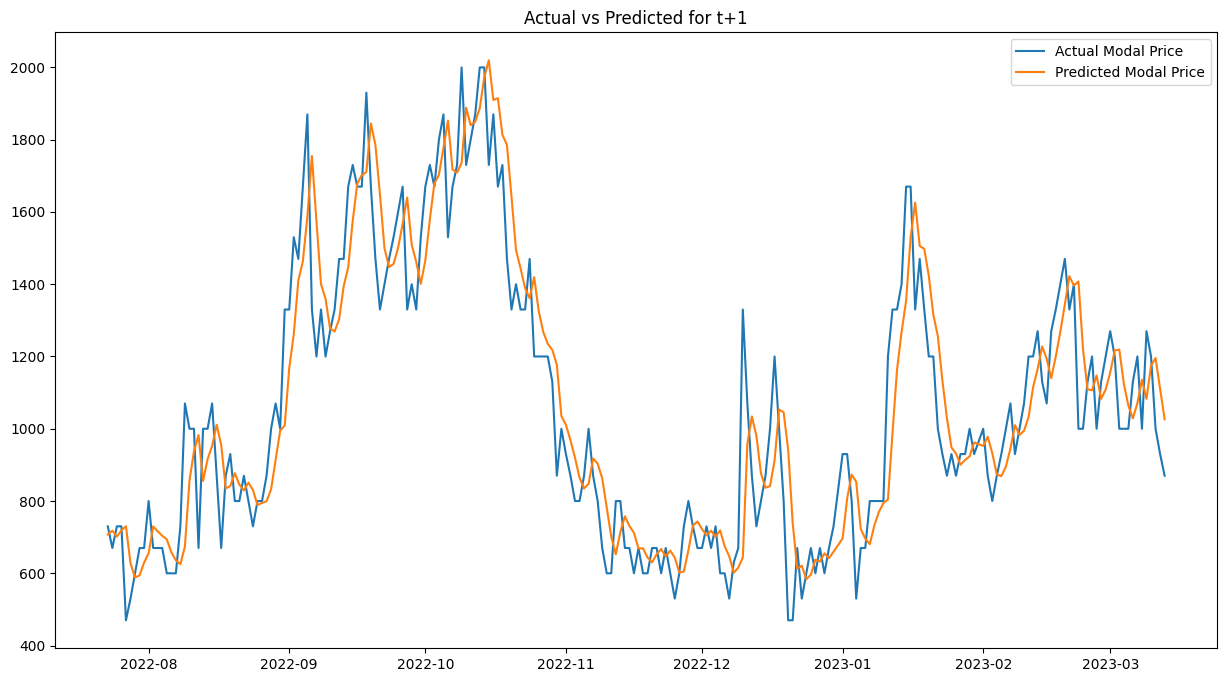

In [69]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Comparing all models

In [70]:
model_comparision

,Seq2Seq_LSTM
MAPE_1,12.257897
MAPE_2,15.687920
MAPE_3,17.379149
MAPE_4,18.255185
MAPE_5,18.868858
